<h1 style="text-align:center;"><u>Unstructured Data Analytics - Assignment 1</u></h1>

<h2 style="text-align:center;">Adithya Murali, Aditya Sindhavad, Advaith Shankar, Manasa Maganti, Shashank Rao, Varsha Manju Jayakumar</h2>

<h3 style="text-align:center;">September 20, 2024</h3>
</h3>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter
from sklearn.manifold import MDS
import nltk
from collections import defaultdict
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

**The below code scrapes al the reviews from the given URL** 

In [2]:
base_url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p'

data = []

for page in range(1, 994):
    url = f'{base_url}{page}'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all comments on the page
    comments = soup.find_all('div', class_='Comment')

    # Extract information for each comment
    for comment in comments:
        # Extract username
        username_tag = comment.find('a', class_='Username')
        username = username_tag.get_text(strip=True) if username_tag else None

        # Extract number of posts
        post_count_tag = comment.find('span', class_='MItem PostCount')
        post_count = post_count_tag.get_text(strip=True).replace('Posts: ', '') if post_count_tag else None

        # Extract date of the review
        date_tag = comment.find('time')
        date = date_tag['datetime'] if date_tag else None

        # Extract review content
        content_tag = comment.find('div', class_='Message userContent')
        content = content_tag.get_text(strip=True) if content_tag else None

        # Append the extracted data to the list
        if username and post_count and date and content:
            data.append([username, post_count, date, content])

    # Print progress
    print(f'Page {page} scraped.')

    # Be polite and avoid overwhelming the server
    time.sleep(1)

# Create a DataFrame with the extracted data
df = pd.DataFrame(data, columns=['Username', 'Number of Posts', 'Date', 'Review'])
df.to_csv('edmunds_forum_messages.csv', index=False)

**We have filtered the latest 5000 records in the backend in excel and loaded it the dataframe**

In [5]:
df = pd.read_csv('Scraped 5000.csv')
brands = pd.read_csv('car_models_and_brands.csv')
df.head(5)

,Username,Number of Posts,Date,Review
0,carnaught,"3,523",2021-05-06T15:45:54+00:00,benjaminhsaid:@explorerx4: How do you like you...
1,benjaminh,"6,362",2021-05-06T01:35:49+00:00,@explorerx4: How do you like your Lincoln MKZ?...
2,benjaminh,"6,362",2020-07-26T22:54:46+00:00,"Yes, I'd like to see Acura bring back a hatchb..."
3,stickguy,"51,285",2020-07-26T22:47:12+00:00,"if they won't bring back Integra, the RSX is a..."
4,benjaminh,"6,362",2020-07-26T22:42:35+00:00,There's speculation that the ILX name might be...


# Part A

In [8]:
all_reviews = " ".join(df['Review'].astype(str))
words = all_reviews.lower().split()
word_counts = Counter(words)
most_common_100 = word_counts.most_common(100)
print(most_common_100)

[('the', 30523), ('a', 15042), ('to', 12857), ('and', 11773), ('i', 10218), ('of', 9357), ('is', 7890), ('in', 7337), ('that', 6932), ('it', 6069), ('for', 5950), ('with', 4842), ('on', 4437), ('you', 4280), ('but', 3838), ('have', 3742), ('my', 3740), ('be', 3633), ('was', 3340), ('not', 3307), ('they', 3262), ('are', 3252), ('as', 3191), ('at', 3177), ('or', 2763), ('car', 2590), ('an', 2434), ('if', 2396), ('would', 2203), ('like', 2153), ('this', 1950), ('just', 1910), ('has', 1909), ('--', 1896), ('so', 1884), ('more', 1842), ('about', 1757), ('than', 1723), ('one', 1708), ('will', 1640), ('all', 1606), ('get', 1604), ('from', 1568), ('can', 1563), ('had', 1515), ('new', 1494), ('what', 1468), ('cars', 1439), ('think', 1360), ('bmw', 1355), ('some', 1331), ("it's", 1300), ('we', 1290), ('no', 1284), ('their', 1270), ('even', 1268), ('up', 1239), ('out', 1213), ('when', 1193), ("don't", 1180), ('do', 1168), ('-', 1163), ('me', 1136), ('your', 1089), ('there', 1036), ('audi', 1001),

**The above is the 100 most common words along with their frequency which have been found in the dataset**

In the pre-processing step we have tokenzied the text and also converted all the words into lower case.
As asked in the question, stop words have not been removed and stemming or lemmatization has not been performed

In short, the theoretical prediction of the law is that the frequency of a word is inversely proportional to its rank. Hence creating another dataframe with this column for easier plotting and testing

Adding another column with theortical frequencies based on Zipf's law

In [13]:
df2 = pd.DataFrame(most_common_100, columns=['Word', 'Frequency'])
df2['Rank'] = df2.index + 1
f1 = df2['Frequency'].iloc[0]  # Frequency of the most common word
df2['Zipf_Theoretical_Frequency'] = f1 / df2['Rank']

Plotting word frequencies against the theoretical predictions based on Zipf's law

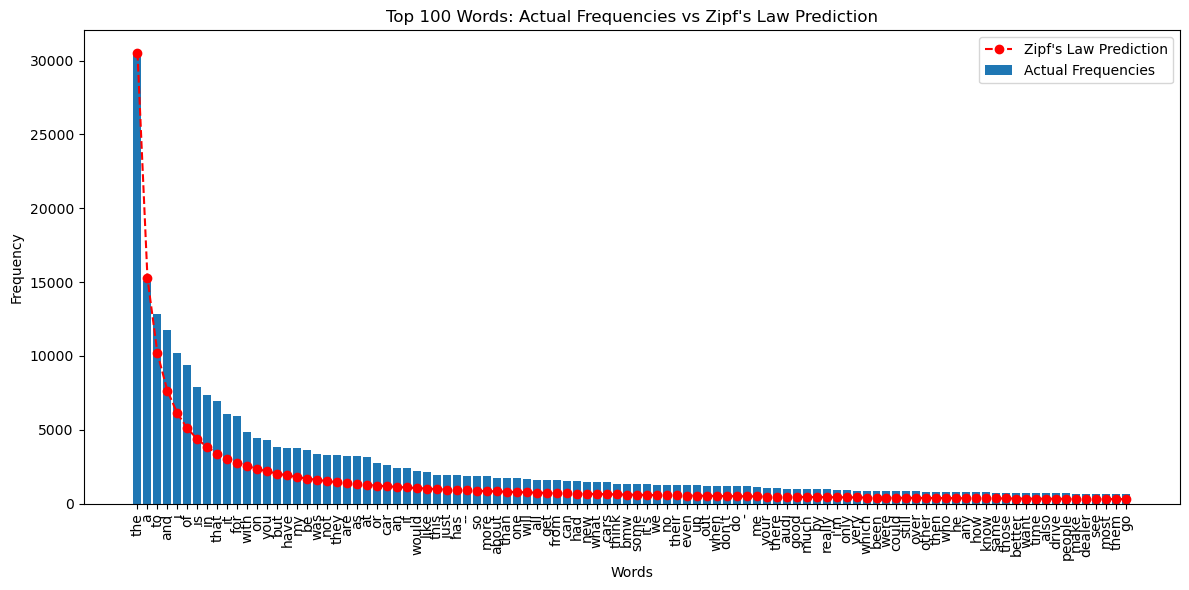

In [16]:
# code to visualize the data frequencies with Zipf's law predictions

plt.figure(figsize=(12, 6))
plt.bar(df2['Word'][:100], df2['Frequency'][:100], label='Actual Frequencies')
plt.plot(df2['Word'][:100], df2['Zipf_Theoretical_Frequency'][:100], label="Zipf's Law Prediction", color='red', marker='o', linestyle='--')

plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title("Top 100 Words: Actual Frequencies vs Zipf's Law Prediction")
plt.xticks(rotation=90) 
plt.legend()

plt.tight_layout()

plt.show()


**Testing of Zipf's law economerically on the top 100 words**

To test this we need to take the log transformation of both the rank and frequency

According to Zipf's law, the relationship between the logarithm of rank and frequency should be approximately linear, with a slope of -1 and hence we perform linear regression for the same

In [18]:
df2['Log_Rank'] = np.log(df2['Rank'])
df2['Log_Frequency'] = np.log(df2['Frequency'])
y, X = dmatrices('Log_Frequency ~ Log_Rank', data=df2, return_type='dataframe')
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Log_Frequency   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     7640.
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           8.61e-95
Time:                        20:33:18   Log-Likelihood:                 95.469
No. Observations:                 100   AIC:                            -186.9
Df Residuals:                      98   BIC:                            -181.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.6688      0.038    279.011      0.0

Plotting to test Zipf's law econometrically

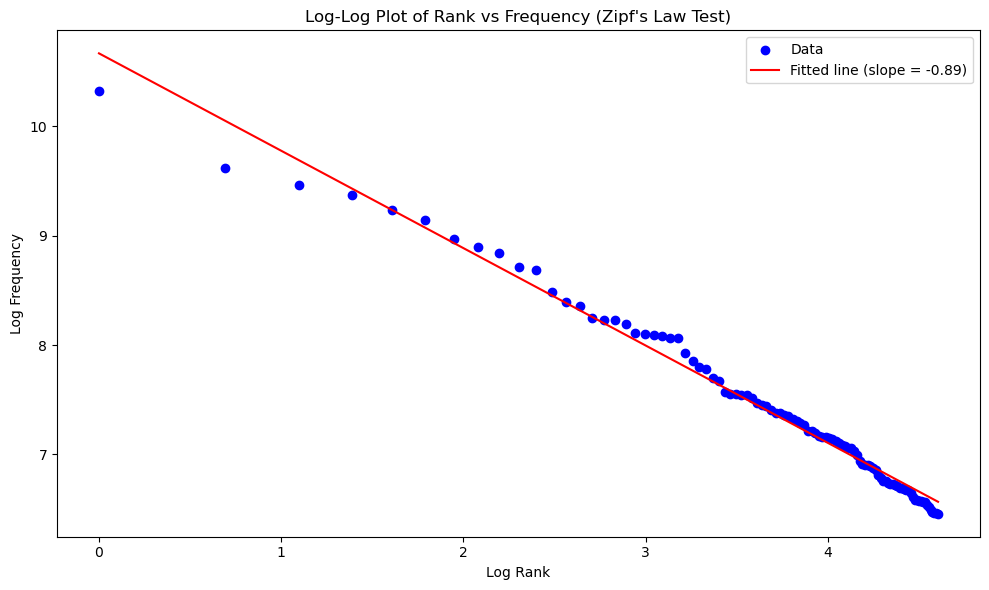

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(df2['Log_Rank'][:100], df2['Log_Frequency'][:100], label='Data', color='blue')
plt.plot(df2['Log_Rank'][:100], results.predict(X), 'r', label=f'Fitted line (slope = {results.params[1]:.2f})')

plt.xlabel('Log Rank')
plt.ylabel('Log Frequency')
plt.title("Log-Log Plot of Rank vs Frequency (Zipf's Law Test)")
plt.legend()
plt.tight_layout()

plt.show()

From looking at the coefficient value of log rank it is ~ -0.90 which is reasonabally close to -1 suggesting there is a trend of Zipf's law in the data.

but we also need to check for the theta value being -1 and less than it using the formula,
ln(r) = Theta.ln.[x(r)/n.x(n)] + E

In [26]:
n = df2['Rank'].max()  
xn = df2['Frequency'].iloc[-1]
df2['Log_Ratio'] = np.log(df2['Frequency'] / (n * xn))

# Regression for theta with the formula ln(r) = theta * ln(x(r) / (n * x(n))) + epsilon
y_theta, X_theta = dmatrices('Log_Rank ~ Log_Ratio', data=df2, return_type='dataframe')
model_theta = sm.OLS(y_theta, X_theta)
results_theta = model_theta.fit()

print(results_theta.summary())

                            OLS Regression Results                            
Dep. Variable:               Log_Rank   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     7640.
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           8.61e-95
Time:                        20:33:27   Log-Likelihood:                 84.522
No. Observations:                 100   AIC:                            -165.0
Df Residuals:                      98   BIC:                            -159.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3915      0.047     -8.281      0.0

The theta coefficient value is -1.1086 which is less than -1. Hence, the condition is satisfied

**Testing of Zipf's law on entire dataset**

In [30]:
df3 = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
df3 = df3.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
df3['Rank'] = df3.index + 1
f1 = df3['Frequency'].iloc[0]
df3['Zipf_Theoretical_Frequency'] = f1 / df3['Rank']
df3['Log_Rank'] = np.log(df3['Rank'])
df3['Log_Frequency'] = np.log(df3['Frequency'])

In [32]:
import statsmodels.api as sm
from patsy import dmatrices
y, X = dmatrices('Log_Frequency ~ Log_Rank', data=df3, return_type='dataframe')
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Log_Frequency   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 1.406e+06
Date:                Fri, 20 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:33:29   Log-Likelihood:                 9584.0
No. Observations:               46688   AIC:                        -1.916e+04
Df Residuals:                   46686   BIC:                        -1.915e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.2733      0.009   1260.047      0.0

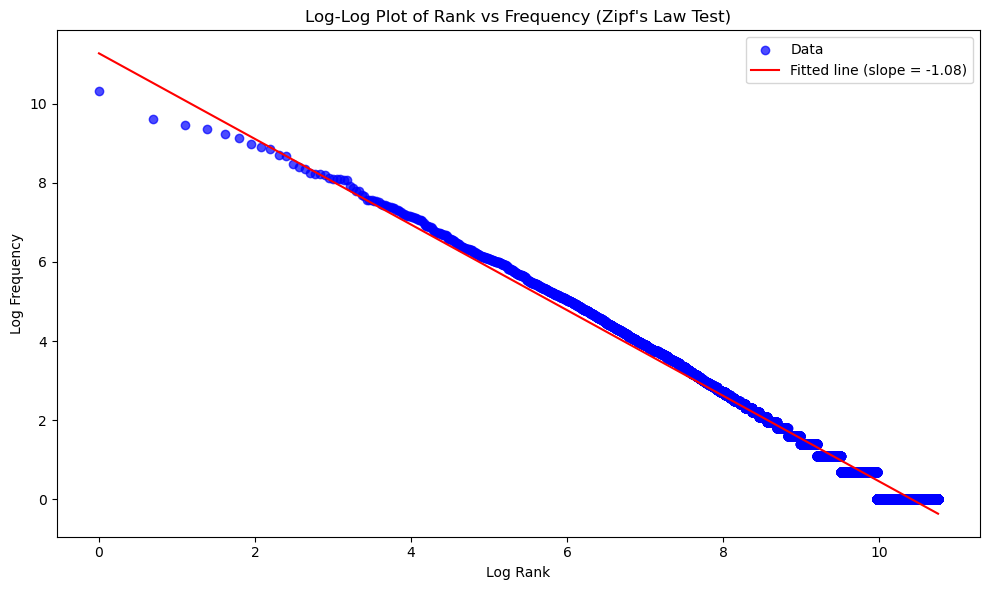

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(df3['Log_Rank'], df3['Log_Frequency'], label='Data', color='blue', alpha=0.7)
plt.plot(df3['Log_Rank'], results.predict(X), 'r', label=f'Fitted line (slope = {results.params[1]:.2f})')
plt.xlabel('Log Rank')
plt.ylabel('Log Frequency')
plt.title("Log-Log Plot of Rank vs Frequency (Zipf's Law Test)")
plt.legend()
plt.tight_layout()
plt.show()

The beta value here is -1.0824 which indicates that there is a trend of Zipf's law in the entire dataset due to it being close to -1.

**Checking for theta value now**

In [38]:
n = df3['Rank'].max()  # Total number of unique words
xn = df3['Frequency'].iloc[-1]  # Frequency of the least common word (x(n))
# Calculate the ratio x(r)/(n * x(n)) and take the log
df3['Log_Ratio'] = np.log(df3['Frequency'] / (n * xn))
# Regression for theta with the formula ln(r) = theta * ln(x(r) / (n * x(n))) + epsilon
y_theta, X_theta = dmatrices('Log_Rank ~ Log_Ratio', data=df3, return_type='dataframe')
model_theta = sm.OLS(y_theta, X_theta)
results_theta = model_theta.fit()

print(results_theta.summary())

                            OLS Regression Results                            
Dep. Variable:               Log_Rank   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 1.406e+06
Date:                Fri, 20 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:33:34   Log-Likelihood:                 14043.
No. Observations:               46688   AIC:                        -2.808e+04
Df Residuals:                   46686   BIC:                        -2.806e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7801      0.008    102.514      0.0

The coefficient value for theta for the entire dataset is ~-0.90 which is close to -1. Which satisifies the trend of Zipf's law in the entire dataset

# Part B

In [42]:
stop_words = set(stopwords.words('english'))

# Remove unwanted words from the brands dataset
to_drop = ['seat', 'sedan', 'car', 'problem'] 
brands = brands[~brands['Brand'].isin(to_drop)] 

brands['Model'] = brands['Model'].str.lower()
brands['Brand'] = brands['Brand'].str.lower()
model_to_brand = dict(zip(brands['Model'].str.lower(), brands['Brand'].str.lower()))


# Function to clean and replace car models with brands in a review
def replace_models_in_review(review, model_to_brand, stop_words):
    review_cleaned = re.sub(r'\W+', ' ', review.lower())
    words = review_cleaned.split()
    found_brands = set([model_to_brand.get(word, word) for word in words]) 
    filtered_brands = {word for word in found_brands if word not in stop_words}
    return ', '.join(filtered_brands)


# Apply the replacement to each review and store as a string of comma-separated brands
df['Brands'] = df['Review'].apply(lambda review: replace_models_in_review(review, model_to_brand, stop_words))

# Use explode logic to separate each brand into its own row and strip any extra spaces
df_exploded = df['Brands'].str.split(',').explode().str.strip()

# Remove empty strings
df_exploded = df_exploded[df_exploded != '']

# Cross-reference: Only consider brands found in the original brands DataFrame
valid_brands = brands['Brand'].unique()
df_exploded_valid = df_exploded[df_exploded.isin(valid_brands)]

# Count the occurrences of each valid brand
brand_counts = df_exploded_valid.value_counts()

top_10_brands = brand_counts.head(10)


In [43]:
print('The top 10 brands with highest frequency after removing the stopwords are:\n' + str(top_10_brands))

The top 10 brands with highest frequency after removing the stopwords are:
Brands
bmw              1241
audi             1001
acura             633
honda             531
volkswagen        297
infiniti          281
toyota            269
cadillac          260
hyundai           252
mercedes-benz     222
Name: count, dtype: int64


# Part C

**Lift calculation between the top 10 brands from 5000 reviews while keeping the window size = 7**

In [48]:
df2=df['Brands']

def count_comentions(review, brand_list, max_distance=7):
    words = set(review.split(", "))
    found_brands = []
    for i, word in enumerate(words):
        if word in brand_list:
            found_brands.append((word, i))
    pairs = []
    if len(found_brands) > 1:
        for i, (brand_a, pos_a) in enumerate(found_brands):
            for brand_b, pos_b in found_brands[i + 1:]:
                if abs(pos_a - pos_b) <= max_distance:
                    pairs.append((brand_a, brand_b))
    return pairs

N = df2.shape[0]
top_10_brands_list = top_10_brands.index.tolist()
co_mention_counts = { (brand_a, brand_b): 0 for i, brand_a in enumerate(top_10_brands_list)
                                              for brand_b in top_10_brands_list[i + 1:] }
for review in df2:
    pairs = count_comentions(review.lower(), top_10_brands_list)
    for pair in pairs:
        if pair in co_mention_counts:
            co_mention_counts[pair] += 1
        elif (pair[1], pair[0]) in co_mention_counts:
            co_mention_counts[(pair[1], pair[0])] += 1

individual_counts = top_10_brands.to_dict()

lift_df = pd.DataFrame(index=top_10_brands_list, columns=top_10_brands_list)

# Calculate lift values for each pair of brands
for i, brand_a in enumerate(top_10_brands_list):
    for j, brand_b in enumerate(top_10_brands_list):
        if i < j:  # Only calculate for unique pairs
            n_a_and_b = co_mention_counts.get((brand_a, brand_b), 0)

            # Count the mentions of each individual brand
            n_a = individual_counts[brand_a]
            n_b = individual_counts[brand_b]

            # Calculate the lift value
            if n_a > 0 and n_b > 0:
                lift_value = (N * n_a_and_b) / (n_a * n_b)
            else:
                lift_value = np.nan
            # Store the lift value in the DataFrame
            lift_df.at[brand_a, brand_b] = np.nan
            lift_df.at[brand_b, brand_a] = lift_value  # Symmetric value

In [50]:
print('The frequency table for top 10 brands are: \n')
lift_df

The frequency table for top 10 brands are: 



,bmw,audi,acura,honda,volkswagen,infiniti,toyota,cadillac,hyundai,mercedes-benz
bmw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
audi,0.273699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acura,0.044555,0.773318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
honda,0.0,0.009407,0.059502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
volkswagen,0.0,0.067273,0.026596,0.095113,NaN,NaN,NaN,NaN,NaN,NaN
infiniti,0.057352,0.497723,0.590309,0.03351,0.0,NaN,NaN,NaN,NaN,NaN
toyota,0.029955,0.018569,0.0,0.700089,2.065262,0.0,NaN,NaN,NaN,NaN
cadillac,0.061985,0.691616,2.035484,0.0,0.0,0.479058,0.07149,NaN,NaN,NaN
hyundai,0.0,0.099107,0.031345,0.373659,0.267222,2.400723,0.368797,0.076313,NaN,NaN
mercedes-benz,0.14519,0.742501,0.853935,0.084831,0.0,0.320605,0.0,1.559252,0.0,NaN


<Axes: >

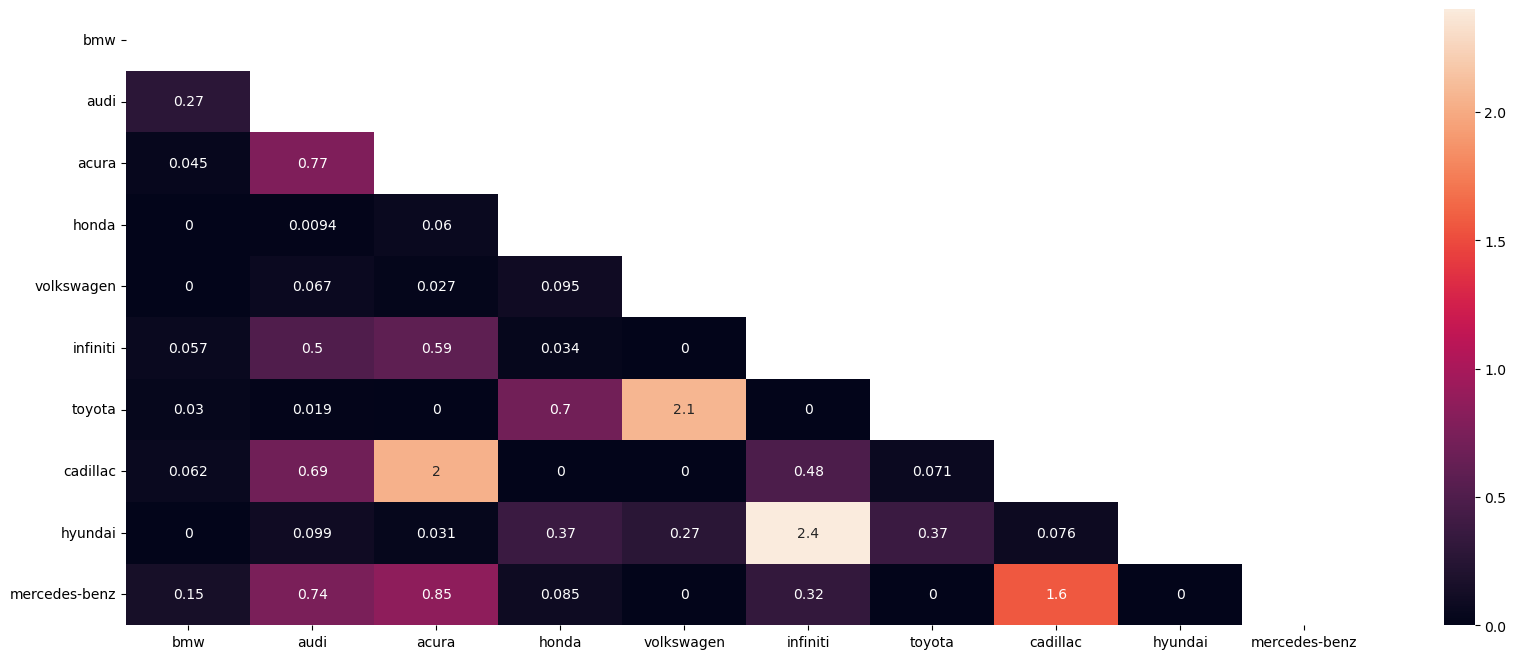

In [52]:
plt.figure(figsize = (20,8))
sns.heatmap(lift_df.fillna(0), annot = True, mask = np.triu(lift_df))

**Window size = 5000 (putting maximum value)**

In [55]:
df2=df['Brands']

def count_comentions(review, brand_list, max_distance=5000):
    words = set(review.split(", "))
    found_brands = []
    for i, word in enumerate(words):
        if word in brand_list:
            found_brands.append((word, i))
    pairs = []
    if len(found_brands) > 1:
        for i, (brand_a, pos_a) in enumerate(found_brands):
            for brand_b, pos_b in found_brands[i + 1:]:
                if abs(pos_a - pos_b) <= max_distance:
                    pairs.append((brand_a, brand_b))
    return pairs

N = df2.shape[0]
top_10_brands_list = top_10_brands.index.tolist()
co_mention_counts = { (brand_a, brand_b): 0 for i, brand_a in enumerate(top_10_brands_list)
                                              for brand_b in top_10_brands_list[i + 1:] }
for review in df2:
    pairs = count_comentions(review.lower(), top_10_brands_list)
    for pair in pairs:
        if pair in co_mention_counts:
            co_mention_counts[pair] += 1
        elif (pair[1], pair[0]) in co_mention_counts:
            co_mention_counts[(pair[1], pair[0])] += 1

individual_counts = top_10_brands.to_dict()

lift_df = pd.DataFrame(index=top_10_brands_list, columns=top_10_brands_list)

# Calculate lift values for each pair of brands
for i, brand_a in enumerate(top_10_brands_list):
    for j, brand_b in enumerate(top_10_brands_list):
        if i < j:  # Only calculate for unique pairs
            n_a_and_b = co_mention_counts.get((brand_a, brand_b), 0)

            # Count the mentions of each individual brand
            n_a = individual_counts[brand_a]
            n_b = individual_counts[brand_b]

            # Calculate the lift value
            if n_a > 0 and n_b > 0:
                lift_value = (N * n_a_and_b) / (n_a * n_b)
            else:
                lift_value = np.nan
            # Store the lift value in the DataFrame
            lift_df.at[brand_a, brand_b] = np.nan
            lift_df.at[brand_b, brand_a] = lift_value  # Symmetric value

# lift_df

In [57]:
print('The frequency table of lift values for top 10 brands are: \n')
lift_df

The frequency table of lift values for top 10 brands are: 



,bmw,audi,acura,honda,volkswagen,infiniti,toyota,cadillac,hyundai,mercedes-benz
bmw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
audi,1.726718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acura,1.222069,1.901732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
honda,1.138138,1.636781,3.138732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
volkswagen,1.166649,2.674094,1.276589,2.029079,NaN,NaN,NaN,NaN,NaN,NaN
infiniti,1.849616,2.470839,3.851062,2.111104,1.318044,NaN,NaN,NaN,NaN,NaN
toyota,1.392929,1.68976,1.556288,3.185405,2.503348,1.65368,NaN,NaN,NaN,NaN
cadillac,1.766565,2.574349,2.157006,1.738375,1.618752,3.148097,1.787246,NaN,NaN,NaN
hyundai,1.167134,1.704645,1.786655,2.129854,2.471808,3.106818,3.245412,1.831502,NaN,NaN
mercedes-benz,2.794898,3.330003,2.597384,1.823858,1.592502,4.328172,1.674537,5.544006,2.234377,NaN


<Axes: >

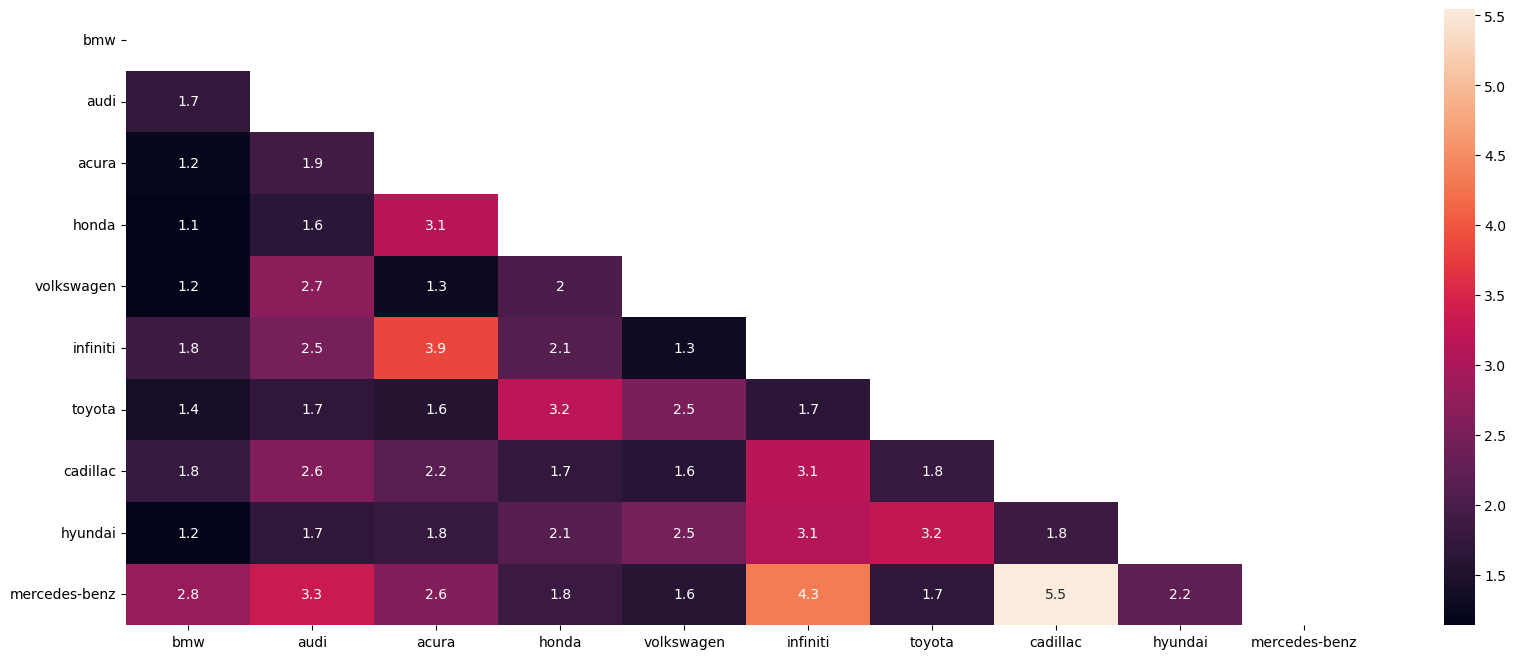

In [59]:
plt.figure(figsize = (20,8))
sns.heatmap(lift_df.fillna(0), annot = True, mask = np.triu(lift_df))

The lift values between few brands(for eg: mercedes-benz, audi) is equal to 0 when we keep the window_size = 7. Hence, we are taking the window_size = 5000 for plotting the MDS plot. 

# Part D

**Creating MDS plot along with K-Means Clustering**

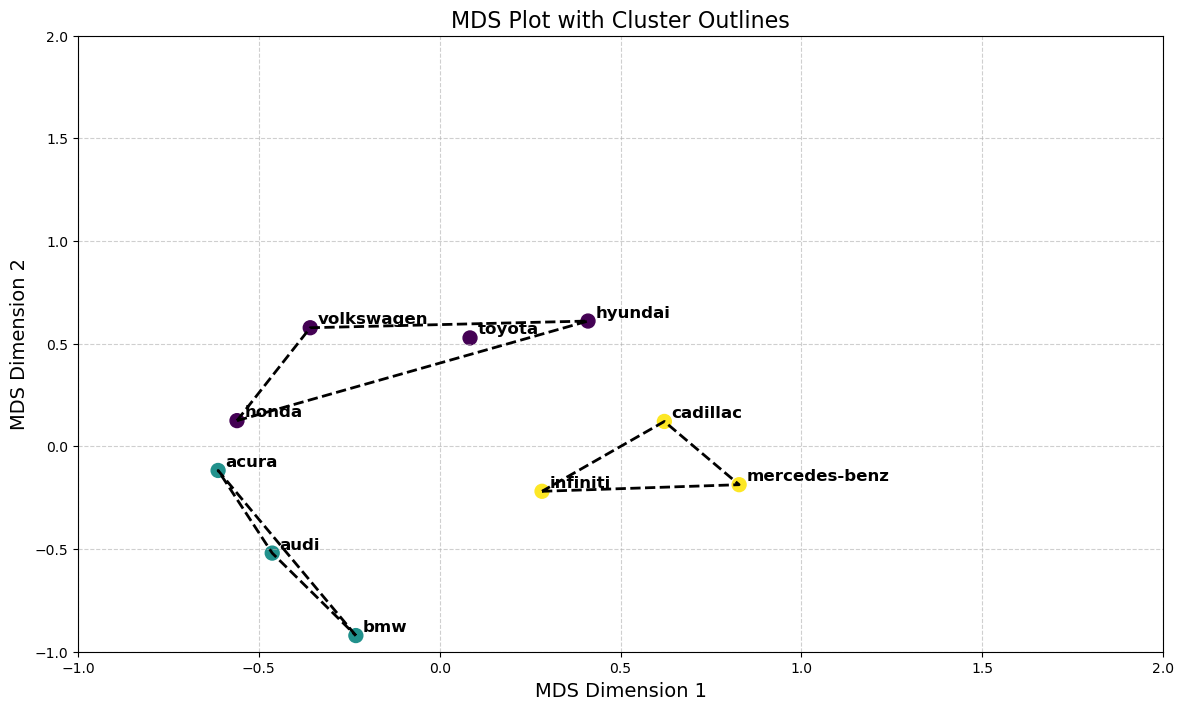

In [64]:
df_lift = pd.DataFrame(lift_df)
df_disimilarity = 1 / df_lift
df_disimilarity.fillna(0, inplace=True)
mds = MDS(n_components=2, random_state=300)
npos = mds.fit_transform(df_disimilarity)
kmeans = KMeans(n_clusters=3, random_state=300)
labels = kmeans.fit_predict(npos)
plt.figure(figsize=(14, 8))
plt.scatter(npos[:, 0], npos[:, 1], s=100, c=labels, cmap='viridis', label='Brands')  # Use color map for clusters
plt.ylim(-1, 2)
plt.xlim(-1, 2)
plt.title('MDS Plot with Cluster Outlines', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
for i in range(len(npos)):
    plt.text(npos[i, 0] + 0.02, npos[i, 1] + 0.02, df_disimilarity.index[i], fontsize=12, fontweight='bold')
# Draw Convex Hulls around each cluster
for cluster_num in np.unique(labels):
    points_in_cluster = npos[labels == cluster_num]
    if len(points_in_cluster) > 2:  # ConvexHull needs at least 3 points
        hull = ConvexHull(points_in_cluster)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # To close the loop
        plt.plot(points_in_cluster[hull_points, 0], points_in_cluster[hull_points, 1], 'k--', lw=2)  # Draw hull
plt.xlabel('MDS Dimension 1', fontsize=14)
plt.ylabel('MDS Dimension 2', fontsize=14)
plt.show()

We can see that there are three distinct clusters from the MDS plot which are as follows:
- Economic Brands: Hyundai, Toyota, Volkswagen, Honda
- Performance Brands: Acura, Audi, BMW
- Luxury Brands: Cadillac, Infiniti, Mercedes-Benz

# Part E

**The MDS plot reveals three distinct clusters:**
- **Economic Brands:** Hyundai, Toyota, Volkswagen, Honda
- **Performance Brands:** Acura, Audi, BMW
- **Luxury Brands:** Cadillac, Infiniti, Mercedes-Benz
- There is a significant distance between BMW and Mercedes-Benz, despite both being luxury brands. This suggests that customers perceive them as quite distinct in terms of brand identity or value propositions, which may stem from different brand positioning strategies, such as performance versus luxury comfort.
- Proximity of Honda and Acura (3.13): Despite Acura being luxury arm of Honda and Honda being economic, their lift values indicate a relatively close association. This suggests that Honda's higher-end models may overlap in customer perception with Acura's entry-level luxury models, indicating potential brand interchangeability for certain customers. 
- Hyundai's proximity to Cadillac and even more so the high lift value with Infinity. This suggests that Hyundai's higher-end models (such as Genesis) may be perceived similarly to Cadillac's entry-level models, indicating Hyundai's success in penetrating the semi-luxury market.

# Part F

**Brand-wise top 5 associated attributes for all the brands**

In [71]:
attribute_counts = defaultdict(int)
for review in df['Review']:
    if isinstance(review, str):
        tokens = nltk.word_tokenize(review.lower())
        attributes = ['luxury','engine', 'performance', 'fuel economy', 'interior', 'exterior', 'reliability', 'safety', 'comfort', 'technology', 'handling']

        for token in tokens:
            if token in attributes:
                attribute_counts[token] += 1

top_5_attributes = sorted(attribute_counts.items(), key=lambda item: item[1], reverse=True)[:5]

print("Top 5 Attributes:")
for attribute, count in top_5_attributes:
    print(f"{attribute}: {count}")

brand_attribute_associations = defaultdict(lambda: defaultdict(int))
for index, row in df.iterrows():
    brands_mentioned = row['Brands'].split(', ')
    for brand in brands_mentioned:
        if brand in top_10_brands.index:  # Consider only the top 10 brands
            # Check if the review is a string before processing
            if isinstance(row['Review'], str):
                review_tokens = nltk.word_tokenize(row['Review'].lower())
                for token in review_tokens:
                    if token in [attribute for attribute, _ in top_5_attributes]:
                        brand_attribute_associations[brand][token] += 1

print("\nBrand-Attribute Associations:")
for brand, attribute_counts in brand_attribute_associations.items():
    print(f"\nBrand: {brand}")
    sorted_attributes = sorted(attribute_counts.items(), key=lambda item: item[1], reverse=True)
    for attribute, count in sorted_attributes:
        print(f"  {attribute}: {count}")

brand_attribute_df = pd.DataFrame.from_dict(brand_attribute_associations, orient='index', columns=[attribute for attribute, _ in top_5_attributes]).fillna(0)

brand_attribute_df = brand_attribute_df.astype(int)

print("\nBrand-Attribute Frequency Table:")
print(brand_attribute_df)

Top 5 Attributes:
luxury: 554
engine: 520
performance: 508
interior: 326
reliability: 214

Brand-Attribute Associations:

Brand: bmw
  performance: 237
  luxury: 232
  engine: 205
  interior: 113
  reliability: 101

Brand: mercedes-benz
  luxury: 90
  performance: 71
  engine: 34
  interior: 34
  reliability: 11

Brand: acura
  luxury: 164
  engine: 121
  performance: 106
  interior: 76
  reliability: 58

Brand: audi
  luxury: 229
  performance: 218
  engine: 164
  interior: 134
  reliability: 111

Brand: honda
  luxury: 116
  engine: 101
  performance: 79
  interior: 57
  reliability: 50

Brand: cadillac
  luxury: 97
  performance: 51
  reliability: 46
  interior: 18
  engine: 15

Brand: infiniti
  luxury: 75
  performance: 55
  engine: 51
  interior: 31
  reliability: 29

Brand: hyundai
  luxury: 107
  performance: 38
  engine: 34
  interior: 23
  reliability: 23

Brand: toyota
  luxury: 70
  reliability: 55
  performance: 52
  interior: 38
  engine: 35

Brand: volkswagen
  luxury: 5

# Part G

### Advice for Client based on Analysis
Based on the analysis of customer reviews, here's some advice for your client:

**1. Focus on Top Brands:**
The top 10 brands mentioned in customer reviews are: bmw, audi, acura, honda, volkswagen, infiniti, toyota, cadillac, hyundai, mercedes-benz.
These brands are clearly popular and occur frequently among different reviews. Consider focusing marketing and product development efforts on these brands.

**2. Identify Brand Associations:**
We've identified associations between brands and key attributes mentioned in customer reviews.
This can help understand which brands are perceived as having specific qualities, such as luxury, performance, or reliability. 

Based on the results, these are the following top 2 attributes for all the 10 brands:
- BMW is often associated with performance, luxury.
- Mercedes-benz is often associated with luxury, performance.
- Audi is often associated with luxury, performance.
- Acura is often associated with luxury, engine.
- Cadillac is often associated with luxury, performance.
- Honda is often associated with luxury, engine.
- Infiniti is often associated with luxury, performance.
- Hyundai is often associated with luxury, performance.
- Toyota is often associated with luxury, reliability.
- Volkswagen is often associated with luxury, interior.

**3. Understand Brand Relationships:**
We've calculated the lift between brand pairs, which helps identify brands that are often mentioned together in reviews.
This can indicate competitive relationships or potential opportunities for cross-promotion or product bundling.
For example, brands with high lift values are often considered together by customers.

**4. Address Top Attributes:**
The top 5 attributes mentioned in reviews are: luxury, engine, performance, interior, reliability.
These are key aspects that customers are focusing on. Ensure that your marketing and product development strategies address these attributes effectively.

**5. Leverage MDS Visualization:**
The MDS visualization can help understand the relationships between brands based on their dissimilarity scores.
This can be a valuable tool for strategic positioning and identifying potential market segments.

**6. Monitor Customer Sentiment:**
Continuously monitor customer reviews and feedback to understand evolving trends and preferences.
This will help you stay ahead of the curve and adapt your strategies accordingly.

By focusing on these key areas, your client can gain a deeper understanding of customer preferences and make informed decisions to improve their marketing and product development strategies.

# Part H

**Replacing the aspirational trigrams and bigrams with "aspiration" and rerunning it on the entire scraped corpus**

In [76]:
def preprocess_review(review):
    
    # Adding aspirational trigrams
    review = re.sub(r"would love to", "aspiration", review)
    review = re.sub(r"am hoping to", "aspiration", review)
    review = re.sub(r"have always wanted", "aspiration", review)
    review = re.sub(r"am planning to", "aspiration", review)
    review = re.sub(r"am eager to", "aspiration", review)
    review = re.sub(r"cant wait to", "aspiration", review)
    review = re.sub(r"really want to", "aspiration", review)
    review = re.sub(r"am dying to", "aspiration", review)
    review = re.sub(r"am determined to", "aspiration", review)
    review = re.sub(r"would love if", "aspiration", review)
    review = re.sub(r"cant wait to", "aspiration", review)

    
    # Adding aspirational bigrams
    review = re.sub(r"aspire to", "aspiration", review)
    review = re.sub(r"aspire of", "aspiration", review)
    review = re.sub(r"dream of", "aspiration", review)
    review = re.sub(r"love to", "aspiration", review)
    review = re.sub(r"wish to", "aspiration", review)
    review = re.sub(r"my dream", "aspiration", review)
    review = re.sub(r"hope to", "aspiration", review)
    review = re.sub(r"want to", "aspiration", review)
    review = re.sub(r"plan to", "aspiration", review)
    review = re.sub(r"aim to", "aspiration", review)
    review = re.sub(r"intend to", "aspiration", review)
    review = re.sub(r"looking to", "aspiration", review)
    review = re.sub(r"desire to", "aspiration", review)
    review = re.sub(r"long to", "aspiration", review)
    review = re.sub(r"eager to", "aspiration", review)
    review = re.sub(r"yearn to", "aspiration", review)
    review = re.sub(r"set on", "aspiration", review)
    review = re.sub(r"keen to", "aspiration", review)
    review = re.sub(r"crave to", "aspiration", review)
    review = re.sub(r"itching to", "aspiration", review)
    review = re.sub(r"determined to", "aspiration", review)
    review = re.sub(r"dying to", "aspiration", review)
    review = re.sub(r"willing to", "aspiration", review)
    review = re.sub(r"ready to", "aspiration", review)
    review = re.sub(r"aspiring to", "aspiration", review)
    return review

df['Review'] = df['Review'].astype(str).apply(preprocess_review)

stop_words = set(stopwords.words('english'))

brands['Model'] = brands['Model'].str.lower()
brands['Brand'] = brands['Brand'].str.lower()

model_to_brand = dict(zip(brands['Model'].str.lower(), brands['Brand'].str.lower()))

def replace_models_in_review(review, model_to_brand, stop_words):
    review_cleaned = re.sub(r'\W+', ' ', review.lower())
    words = review_cleaned.split()

    found_brands = set([model_to_brand.get(word, word) for word in words]) 

    filtered_brands = {word for word in found_brands if word not in stop_words}

    return ', '.join(filtered_brands)

df['Brands'] = df['Review'].astype(str).apply(lambda review: replace_models_in_review(review, model_to_brand, stop_words))

df_exploded = df['Brands'].str.split(',').explode().str.strip()

df_exploded = df_exploded[df_exploded != '']

valid_brands = brands['Brand'].unique()
df_exploded_valid = df_exploded[df_exploded.isin(valid_brands)]

brand_counts = df_exploded_valid.value_counts()

top_10_brands = brand_counts.head(10)

print(top_10_brands)

Brands
bmw              1241
audi             1001
acura             633
honda             531
volkswagen        297
infiniti          281
toyota            269
cadillac          260
hyundai           252
mercedes-benz     222
Name: count, dtype: int64


In [77]:
top_10_brands_dict = top_10_brands.to_dict()
print(top_10_brands_dict)
word_freq = top_10_brands_dict

{'bmw': 1241, 'audi': 1001, 'acura': 633, 'honda': 531, 'volkswagen': 297, 'infiniti': 281, 'toyota': 269, 'cadillac': 260, 'hyundai': 252, 'mercedes-benz': 222}


           Brand  Lift
0            bmw  1.52
1           audi  1.81
2          acura  1.44
3          honda  1.59
4     volkswagen  1.49
5       infiniti  2.10
6         toyota  1.59
7       cadillac  2.10
8        hyundai  1.74
9  mercedes-benz  2.48


<Axes: xlabel='Brand'>

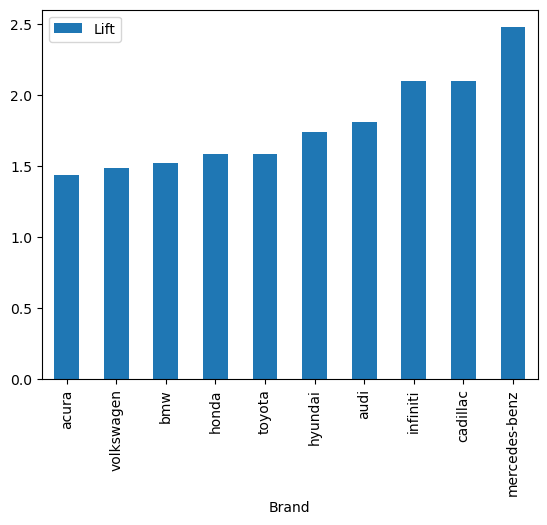

In [78]:
def liftCalc_with_aspire(word_1, word_2):
    w1freq = sum(df.apply(lambda x: word_1 in x['Brands'], axis=1))
    w2freq = sum(df.apply(lambda x: word_2 in x['Review'], axis=1))
    bothfreq = sum(df.apply(lambda x: word_1 in x['Brands'] and word_2 in x['Review'], axis=1))

    if w1freq == 0 or w2freq == 0:
        return 0

    return float(bothfreq/len(df))/((float(w1freq)/len(df))*(float(w2freq)/len(df)))

brand_aspire_lifts = {}

for brand in top_10_brands.index:
    lift = liftCalc_with_aspire(brand, 'aspiration')
    brand_aspire_lifts[brand] = lift


df_lifts = pd.DataFrame(list(brand_aspire_lifts.items()), columns=['Brand', 'Lift'])
df_lifts['Lift'] = df_lifts['Lift'].round(2)

print(df_lifts)

df_lifts.sort_values(by = 'Lift').plot(x = 'Brand', y='Lift', kind = 'bar')

As we can see, Infiniti, Cadillac and Mercedes-Benz which we associate as luxury brands have the highest aspirational lift values which indicate that these are the brands that people sought after. 